# Applying Machine Learning on UrbanSound8k

## Install Packages

We install:
- Machine learning libraries: `Keras`, `sklearn`
- Audio processing: `librosa`
- Plots: `Plotly`, `matplotlib`

In [1]:
!pip install pandas
!pip install setuptools
!pip install numpy
!pip install sklearn
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install pillow
!pip install keras

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import os
import time
import librosa
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [35]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    shutil.copy(os.path.join(dataset_path, 'urban8k.tgz'), '/content')
except Exception as err:
    print(str(err))

!tar -xzf urban8k.tgz
!rm urban8k.tgz

In [3]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2023-11-26 22:37:02--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2023-11-26 22:37:03--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  20.6MB/s    in 4m 54s  

2023-11-26 22:41:57 (19.6 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



## Design Choices and Models

After analysing the dataset and spending a bit of time reading about state-of-the-art on audio signal classification, and some of my [previous work](https://github.com/jsalbert/Music-Genre-Classification-with-Deep-Learning) I have made the following design choices and proposals:

Train a Convolutional Neural Network and use either MFCCs, STFT or Mel-Spectogram as input.

- As the audios duration range from 0 to 4s, I pad the spectogram generated, to make all the audios of equal length.

Feature options:

- Using MFCCs as features:
  - It is usual to compute the first 13 MFCCs, their derivatives and second derivatives and use it as features.
  - Or it is also usual to use 40 MFCCs as it is the Librosa default.

- Using the STFT as features:
  - Contains less human processing than MFCCs and Mel-Spectogram, the CNN could learn other filters rather than the representations designed by humans.

- Using Mel-Spectogram as features:
  - A transformation applied on the STFT that approximates how humans perceive the sound. Less human engineered than MFCCs but a bit more than STFT.

My first choice would be using STFT and Mel-Spectogram as it looks that CNNs could take more advantage of the frequency-temporal structure but due to **computational resources** and limited time I will show the use **MFCCs** as features as they are much more memory efficient.


## Dataset Preprocessing and Splits

I load all the audio data using Librosa and the default sample rate of 22050Hz. This design decision is based on
([Source]((https://librosa.org/blog/2019/07/17/resample-on-load/#Okay...-but-why-22050-Hz?--Why-not-44100-or-48000?))) and in further experiments different sample rates could be tried.

> Humans can hear up to around 20000 Hz, it's possible to successfully analyze music and speech data at much lower rates without sacrificing much. The highest pitches we usually care about detecting are around C9≈8372 Hz, well below the 11025 cutoff implied by fs=22050.

By default Librosa will load the audio in mono, giving us 1 channel.



In [4]:
# FeatureExtractor class including librosa audio processing functions
class FeatureExtractor:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.max_audio_duration = 4
        self.dataset_df = self._create_dataset(csv_file)

    @staticmethod
    def _create_dataset(csv_file):
        """
        Args:
            dataset_path: path with the .wav files after unzipping
        Returns: A pandas dataframe with the list of files and labels (`filenames`, `labels`)
        """
        dataset_df = pd.read_csv(csv_file)
        filepaths = []
        for i, row in dataset_df.iterrows():
            filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
        dataset_df['filepath'] = filepaths
        return dataset_df

    @staticmethod
    def _compute_max_pad_length(max_audio_length, sample_rate=22050, n_fft=2048, hop_length=512):
        dummy_file = np.random.random(max_audio_length*sample_rate)
        stft = librosa.stft(dummy_file, n_fft=n_fft, hop_length=hop_length)
        # Return an even number for CNN computation purposes
        if stft.shape[1] % 2 != 0:
            return stft.shape[1] + 1
        return stft.shape[1]

    def compute_save_features(self,
                        mode='mfcc',
                        sample_rate=22050,
                        n_fft=2048,
                        hop_length=512,
                        n_mfcc=40,
                        output_path='features',
                        deltas=False
                        ):
        dataset_features = []
        max_pad = self._compute_max_pad_length(self.max_audio_duration,
                                               sample_rate=sample_rate,
                                               n_fft=n_fft,
                                               hop_length=hop_length)
        print('Max Padding = ', max_pad)

        if not os.path.exists(output_path):
            print('Creating output folder: ', output_path)
            os.makedirs(output_path)
        else:
            print('Output folder already existed')

        print('Saving features in ', output_path)
        i = 0
        t = time.time()

        features_path = []
        for filepath in self.dataset_df['filepath']:
            if i % 100 == 0:
                print('{} files processed in {}s'.format(i, time.time() - t))
            audio_file, sample_rate = librosa.load(filepath, sr=sample_rate, res_type='kaiser_fast')
            if mode == 'mfcc':
                audio_features = self.compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas)
            elif mode == 'stft':
                audio_features = self.compute_stft(audio_file, sample_rate, n_fft, hop_length)
            elif mode == 'mel-spectogram':
                audio_features = self.compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length)

            audio_features = np.pad(audio_features,
                                    pad_width=((0, 0), (0, max_pad - audio_features.shape[1])))

            save_path = os.path.join(output_path, filepath.split('/')[-1].replace('wav', 'npy'))
            self.save_features(audio_features, save_path)
            features_path.append(save_path)
            i+=1
        self.dataset_df['features_path'] = features_path
        return self.dataset_df

    @staticmethod
    def save_features(audio_features, filepath):
        np.save(filepath, audio_features)

    @staticmethod
    def compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length):
        return librosa.feature.melspectrogram(audio_file,
                                              sr=sample_rate,
                                              n_fft=n_fft,
                                              hop_length=hop_length)
    @staticmethod
    def compute_stft(audio_file, sample_rate, n_fft, hop_length):
        return librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)

    @staticmethod
    def compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas=False):
        mfccs = librosa.feature.mfcc(audio_file,
                                    sr=sample_rate,
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    )
        # Change mode from interpolation to nearest
        if deltas:
          delta_mfccs = librosa.feature.delta(mfccs, mode='nearest')
          delta2_mfccs = librosa.feature.delta(mfccs, order=2, mode='nearest')
          return np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return mfccs

In [5]:
# Create dataset and extract features
fe = FeatureExtractor('UrbanSound8K/metadata/UrbanSound8K.csv')

Access to disc and librosa loading of audio files is very slow on colab Notebook (30-40 min) we could load the pre-computed features instead.

In [6]:
# Uncomment and run to compute and save features on the colab notebook
# dataset_df = fe.compute_save_features(mode='mfcc', n_mfcc=13, output_path='features_mfcc', deltas=True)

In [7]:
# Unzip features
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H" -O features_mfcc.zip && rm -rf /tmp/cookies.txt
!unzip -q features_mfcc.zip
!rm features_mfcc.zip

--2023-11-26 22:43:44--  https://docs.google.com/uc?export=download&confirm=t&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H
Resolving docs.google.com (docs.google.com)... 64.233.170.113, 64.233.170.139, 64.233.170.100, ...
Connecting to docs.google.com (docs.google.com)|64.233.170.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lp8nd4fuql1sarov3j6k1eca57e6te7m/1701038550000/12555612686504083087/*/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download&uuid=fd6c0ba6-de7b-4d51-9af1-eb4858ca3afa [following]
--2023-11-26 22:43:44--  https://doc-00-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lp8nd4fuql1sarov3j6k1eca57e6te7m/1701038550000/12555612686504083087/*/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download&uuid=fd6c0ba6-de7b-4d51-9af1-eb4858ca3afa
Resolving doc-00-1k-docs.googleusercontent.com (doc-00-1k-docs.googleusercontent.com)... 172.253.118.132,

In [8]:
# Download dataset.json file
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C" -O dataset.json

--2023-11-26 22:43:55--  https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C
Resolving docs.google.com (docs.google.com)... 64.233.170.113, 64.233.170.139, 64.233.170.100, ...
Connecting to docs.google.com (docs.google.com)|64.233.170.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/skngpu80jfb1acmn6r4firprsd4sthlj/1701038625000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download&uuid=fa479ab2-a343-4e5b-a43a-d5ecf53af0f0 [following]
--2023-11-26 22:43:56--  https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/skngpu80jfb1acmn6r4firprsd4sthlj/1701038625000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download&uuid=fa479ab2-a343-4e5b-a43a-d5ecf53af0f0
Resolving doc-0s-1k-docs.googleusercontent.com (doc-0s-1k-docs.googleusercontent.com)... 172.253.118.132, 2404:6800

In [9]:
dataset_df = pd.read_json('dataset.json')

For the purpose of this experiment we will load all the data in memory and process it in minibatches. If we had computational resources and more time we could create Dataloader objects that would allow to perform many other operations as Data Augmentation and iterate faster.

In [10]:
dataset_df['features'] = [np.asarray(np.load(feature_path)) for feature_path in dataset_df['features_path']]

In [11]:
from keras.utils import to_categorical
dataset_df['labels_categorical'] = [to_categorical(label, 10) for label in dataset_df['classID']]

In [12]:
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath,features_path,features,labels_categorical
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav,features_mfcc/100032-3-0-0.npy,"[[[-306.77255], [-177.59209], [-99.13616], [-6...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav,features_mfcc/100263-2-0-117.npy,"[[[-457.69534], [-451.0248], [-450.68613], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav,features_mfcc/100263-2-0-121.npy,"[[[-468.0367], [-467.42264], [-481.04654], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav,features_mfcc/100263-2-0-126.npy,"[[[-422.42215], [-411.9085], [-409.46243], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav,features_mfcc/100263-2-0-137.npy,"[[[-438.10162], [-434.47787], [-443.3284], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


We are going to create splits for the train, validation and test sets of our dataset.
For the purpose of the experiment and to make it quick we will use the sklearn function `train_test_split`, two times.

In [13]:
# Split the dataset
from sklearn.model_selection import train_test_split

# Add one dimension for the channel
X = np.array(dataset_df['features'].tolist())
y = np.array(dataset_df['labels_categorical'].tolist())

# As there is unbalance for some classes I am going to stratify it so we have the same proportion in train/test
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=1,
                                                    stratify=y)
# Create validation and test
X_test, X_val, Y_test, Y_val = train_test_split(X_test,
                                                Y_test,
                                                test_size=0.5,
                                                random_state=1,
                                                stratify=Y_test)

print(X_train.shape, X_val.shape, X_test.shape)

(6112, 39, 174, 1) (1310, 39, 174, 1) (1310, 39, 174, 1)


## Machine Learning Model

### Model Design

We are going to create a **Fully Convolutional Network** Model using Keras running over Tensorflow with a few layers.

In [14]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

As our images are rectangular in shape (y axis is MFCC, x axis is time), instead of using square filters (as usual) we are going to make them rectangular so they can learn better the correlation of the MFCCs with the temporal dimension.

In [15]:
# FCN Model
def create_model(num_classes=10, input_shape=None, dropout_ratio=None):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 3)))
    model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(GlobalAveragePooling2D())
    if dropout_ratio is not None:
        model.add(Dropout(dropout_ratio))
    # Add dense linear layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

As it is a multi classification problem we will use the **Categorical Cross Entropy loss**. As optimizer we will use the Keras implementation of **Adam** with the default hyperparameters values.

In [16]:
# Create and compile the model
fcn_model = create_model(input_shape=X_train.shape[1:])
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 171, 16)       144       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 57, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 54, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 27, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 24, 64)         16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 12, 64)         0

### Model training and evaluation

In [17]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [18]:
!mkdir saved_models

In [19]:
def train_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size, callbacks):
    model.fit(X_train,
              Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, Y_val),
              callbacks=callbacks, verbose=1)
    return model

We will create a checkpoint for **early stopping**, so we will select the model that performs better on the validation set.

Creating a function to train the model will allow us to perform hyperparameter tuning faster.

In [20]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_fcn.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks = [checkpointer]

# Hyper-parameters
epochs = 100
batch_size = 256

In [21]:
# Train the model
model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 2.1897 - accuracy: 0.2665
Epoch 1: val_accuracy improved from -inf to 0.36947, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 14s 67ms/step - loss: 2.1897 - accuracy: 0.2665 - val_loss: 1.7382 - val_accuracy: 0.3695
Epoch 2/100
 7/24 [=======>......................] - ETA: 0s - loss: 1.6433 - accuracy: 0.4241

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/24 [==========================>...] - ETA: 0s - loss: 1.5123 - accuracy: 0.4638
Epoch 2: val_accuracy improved from 0.36947 to 0.50611, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 1s 25ms/step - loss: 1.4974 - accuracy: 0.4707 - val_loss: 1.3657 - val_accuracy: 0.5061
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 1.2457 - accuracy: 0.5589
Epoch 3: val_accuracy improved from 0.50611 to 0.58397, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 1s 25ms/step - loss: 1.2457 - accuracy: 0.5589 - val_loss: 1.1984 - val_accuracy: 0.5840
Epoch 4/100
22/24 [==========================>...] - ETA: 0s - loss: 1.1373 - accuracy: 0.6076
Epoch 4: val_accuracy improved from 0.58397 to 0.59466, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 1s 25ms/step - loss: 1.1332 - accuracy: 0.6080 - val_loss: 1.1556 - val_accuracy: 0.5947
Epoch 5/100
22/24 [=====================

In [22]:
# Load the best model
best_model = load_model('saved_models/best_fcn.hdf5')

Looks like the model has overfitted to the training data towards the end of the training. We have selected the model that performed better on the validation set, saved by the checkpoint. The similarity between validation and test score tells us that our training methodology is correct and that our validation set is a good estimator of testing performance.

In [23]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9975458383560181
Validation Accuracy:  0.9114503860473633
Testing Accuracy:  0.8954198360443115


We see that there has been overfitting so we could train another model adding dropout before the last layer to add more regularization.  

In [24]:
# We add a dropout ratio of 0.25
fcn_model = create_model(input_shape=X_train.shape[1:], dropout_ratio=0.5)
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 38, 171, 16)       144       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 19, 57, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 54, 32)        4128      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 9, 27, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 24, 64)         16448     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 12, 64)        

In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_fcn_dropout.hdf5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
callbacks = [checkpointer]

model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=200,
                    batch_size=256,
                    callbacks=callbacks)

Epoch 1/200
24/24 [==============================] - ETA: 0s - loss: 2.6270 - accuracy: 0.1643
Epoch 1: val_accuracy improved from -inf to 0.28626, saving model to saved_models/best_fcn_dropout.hdf5
24/24 [==============================] - 3s 38ms/step - loss: 2.6270 - accuracy: 0.1643 - val_loss: 1.9807 - val_accuracy: 0.2863
Epoch 2/200
22/24 [==========================>...] - ETA: 0s - loss: 1.9173 - accuracy: 0.2869
Epoch 2: val_accuracy improved from 0.28626 to 0.40840, saving model to saved_models/best_fcn_dropout.hdf5
24/24 [==============================] - 1s 26ms/step - loss: 1.9123 - accuracy: 0.2894 - val_loss: 1.6746 - val_accuracy: 0.4084
Epoch 3/200
22/24 [==========================>...] - ETA: 0s - loss: 1.6556 - accuracy: 0.4086
Epoch 3: val_accuracy improved from 0.40840 to 0.49771, saving model to saved_models/best_fcn_dropout.hdf5
24/24 [==============================] - 1s 24ms/step - loss: 1.6508 - accuracy: 0.4107 - val_loss: 1.4298 - val_accuracy: 0.4977
Epoch 4

In [26]:
best_model = load_model('saved_models/best_fcn_dropout.hdf5')

In [27]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9980366230010986
Validation Accuracy:  0.9229007363319397
Testing Accuracy:  0.9053435325622559


In [28]:
# Plot a confusion matrix
from sklearn import metrics
Y_pred = best_model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

41/41 [==============================] - 0s 2ms/step


In [29]:
# Confusion matrix code (from https://github.com/triagemd/keras-eval/blob/master/keras_eval/visualizer.py)
def plot_confusion_matrix(cm, concepts, normalize=False, show_text=True, fontsize=18, figsize=(16, 12),
                          cmap=plt.cm.coolwarm_r, save_path=None, show_labels=True):
    '''
    Plot confusion matrix provided in 'cm'
    Args:
        cm: Confusion Matrix, square sized numpy array
        concepts: Name of the categories to show
        normalize: If True, normalize values between 0 and ones. Not valid if negative values.
        show_text: If True, display cell values as text. Otherwise only display cell colors.
        fontsize: Size of text
        figsize: Size of figure
        cmap: Color choice
        save_path: If `save_path` specified, save confusion matrix in that location
    Returns: Nothing. Plots confusion matrix
    '''

    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError('Invalid confusion matrix shape, it should be square and ndim=2')

    if cm.shape[0] != len(concepts) or cm.shape[1] != len(concepts):
        raise ValueError('Number of concepts (%i) and dimensions of confusion matrix do not coincide (%i, %i)' %
                         (len(concepts), cm.shape[0], cm.shape[1]))

    plt.rcParams.update({'font.size': fontsize})

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm_normalized

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, vmin=np.min(cm), vmax=np.max(cm), alpha=0.8, cmap=cmap)

    fig.colorbar(cax)
    ax.xaxis.tick_bottom()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

    if show_labels:
        n_labels = len(concepts)
        ax.set_xticklabels(concepts)
        ax.set_yticklabels(concepts)
        plt.xticks(np.arange(0, n_labels, 1.0), rotation='vertical')
        plt.yticks(np.arange(0, n_labels, 1.0))
    else:
        plt.axis('off')

    if show_text:
        # http://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot
        min_val, max_val = 0, len(concepts)
        ind_array = np.arange(min_val, max_val, 1.0)
        x, y = np.meshgrid(ind_array, ind_array)
        for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
            c = cm[int(x_val), int(y_val)]
            ax.text(y_val, x_val, c, va='center', ha='center')

    if save_path is not None:
        plt.savefig(save_path)

To observe better the performance of the model and the mistakes made between different classes we plot the confusion matrix.

In our case accuracy is a good metric because the dataset is mostly balanced but we observed a few classes with less samples (1`car_horn`, `gun_shot` and `siren`), so it will be good to observe the performance on these classes.

We can observe that a lot of mistakes are happening between class `children_playing` and class `street_music` so maybe it will be worth it to spend a little bit more time doing analysis and finding what could be the reasons.  

In [30]:
class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

<ipython-input-29-2680bce05b12>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(concepts)
<ipython-input-29-2680bce05b12>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(concepts)


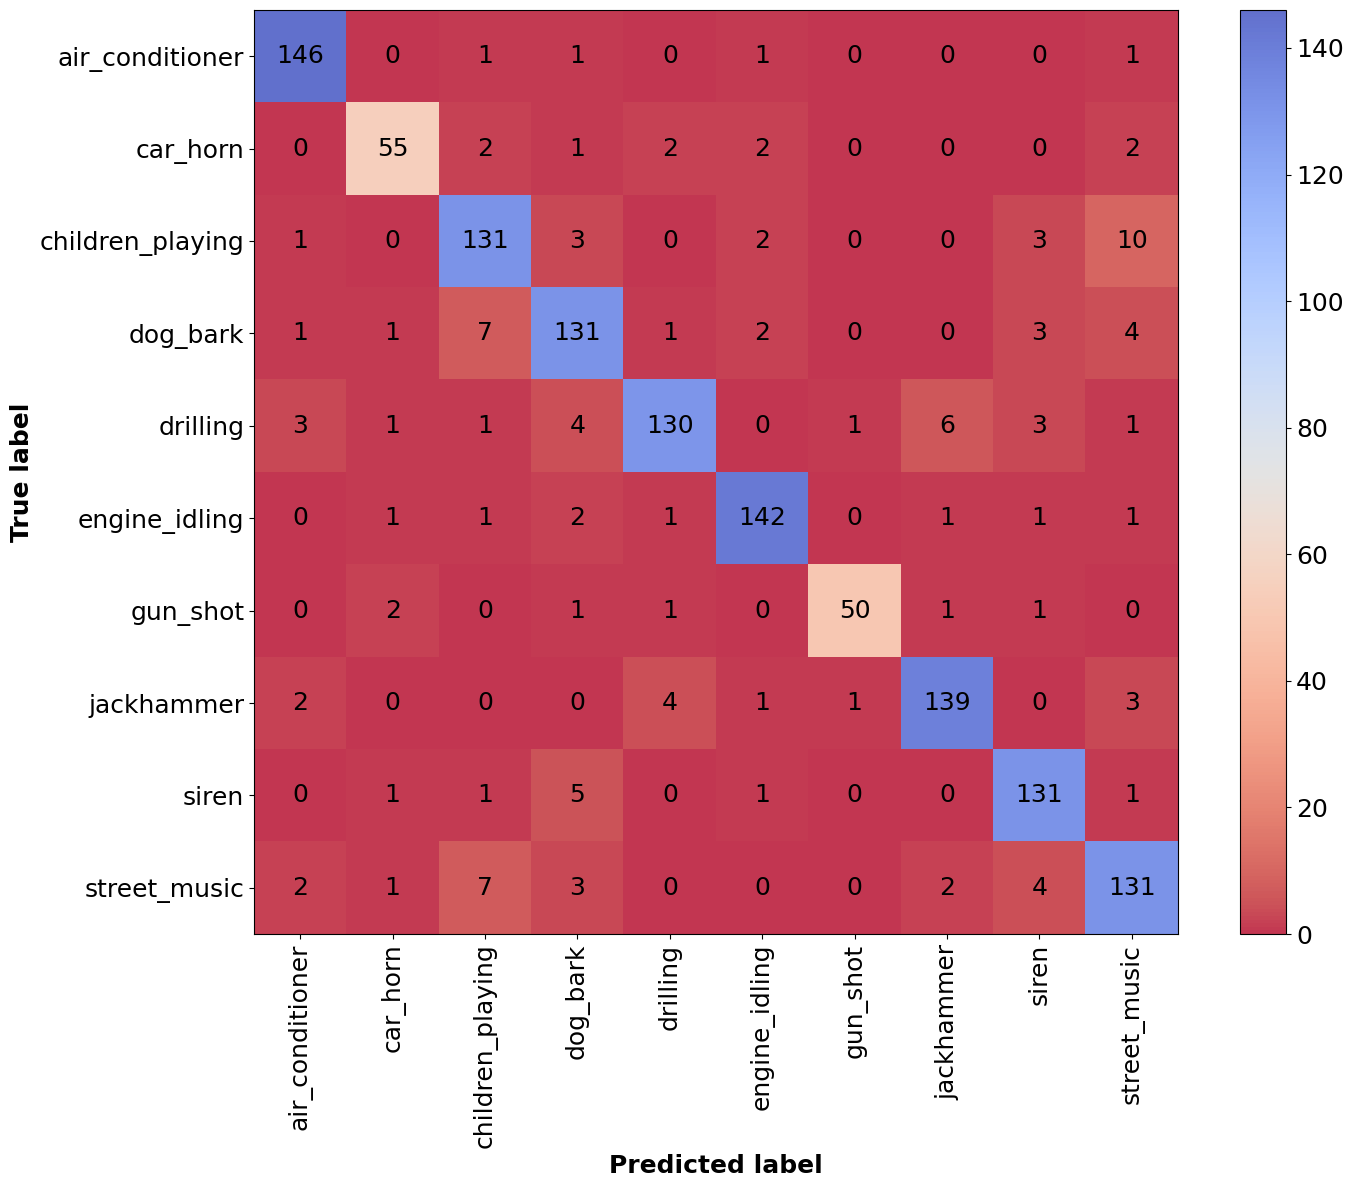

In [31]:
plot_confusion_matrix(matrix, classes)

## Conclusions

We can observe a bump of 1-2% in the test set accuracy when introducing dropout as regularization. This shows that it has been a successful addition to our model.

There are many things that we can try to improve the model's performance such as:

- Hyperparameter tuning:
  - Tuning the parameters of feature extraction
  - Tuning the network parameters (number of layers, pooling layers, number and filter shape...)
  - Tuning the network hyperparameters (Learning rate, optimizer)

- Feature extraction:
  - Use STFT: The raw spectogram could provide more information to the CNN to learn correlation between frequency and time than the MFCCs.
  - Use Mel-Spectogram: The mel-spectogram could provide more information to the CNN to learn correlation between frequency and time than the MFCCs.